# NLP HW2: BBC Dataset

*by Alexander Marinskiy*

## Task
Classify news to one of 5 categories based on text

1. Choose and argue your measure of a test's accuracy
2. Build data processing and classification pipeline
3. Tune  your model


In [1]:
# import libraries

import os
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [2]:
# ignore warnings
warnings.filterwarnings("ignore")

## 1. Get Data 

In [3]:
# initialize dataframe
df = pd.DataFrame()

# initialize variables
texts = []
labels = []
titles = []

# walk through all the files in dataset
for subdir, dirs, files in os.walk('dataset'):
    for file in files:
        
        # get texts
        with open(os.path.join(subdir, file), 'r') as doc:
            texts.append(' '.join(doc.readlines()).replace('\n', ''))   
        # get labels
        labels.append(subdir.split('\\')[-1])

# fill dataframe
df['text'] = texts
df['label'] = labels


In [4]:
# Check what dataframe looks like
df.head(n=5)

,text,label
0,Ad sales boost Time Warner profit Quarterly p...,business
1,Dollar gains on Greenspan speech The dollar h...,business
2,Yukos unit buyer faces loan claim The owners ...,business
3,High fuel prices hit BA's profits British Air...,business
4,Pernod takeover talk lifts Domecq Shares in U...,business


In [5]:
print('There are', df.shape[0], 'rows and', df.shape[1], 'columns in our dataset')

There are 2225 rows and 2 columns in our dataset


In [6]:
# let's check the distribution of labels in dataset
df["label"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

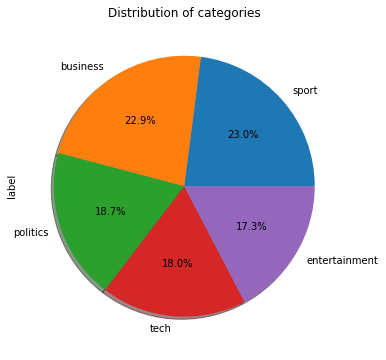

In [7]:
# Visualizing the distribution
df["label"].value_counts().plot(kind = 'pie', figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.title('Distribution of categories')
plt.show()

We can see that the dataset is almost balanced.

## 2. Choosing metric for quality

We are facing with the task of **multiclass classification** in a **balanced dataset**. Since the dataset is balanced, it is reasonable to use average accuracy or macro averaged f1 score as metrics. I will use average accuracy because this metric is more intuitive.

## 3. Initialize Vectorizers and Models

It's important to note during process ov vectorization that we **can not use vectorization on the whole dataset** because in this approach we may **leak test data to our model**, even though we don't feed it explicitly. Such values as size of vocabulary and IDF value of each term in vocabulary may differ when test documents are included in vectorization. In order to get a correct evaluation of the quality of the model, we need to fit the vectorizer for each fold of cross validation separately.

In [8]:
# make dictionary with names of vectorizers and vectorizers
vecrotizers={'Tf-idf vectorizer': TfidfVectorizer(sublinear_tf=True, 
                                                  min_df=5, 
                                                  norm='l2', 
                                                  encoding='latin-1', 
                                                  ngram_range=(1, 2), 
                                                  stop_words='english'),
             'Count vectorizer': CountVectorizer(min_df=5, 
                                                 encoding='latin-1', 
                                                 stop_words='english', 
                                                 ngram_range=(1, 2))}

Now lets create dictionary with models to choose from. I choosed one tree-based model, one bayasian model and one linear model. 

In [9]:
# create dictionary with models
models = {'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
          'Multinomial Naive Bayes': MultinomialNB(),
          'Logistic Regression': LogisticRegression(random_state=42)}

## 4. Model selection

Now, lets get scores for each model and each vectorizer:

In [10]:
# Function to get scores for specific vectorizer and model. 
def evaluate_model(X, y, vectorizer_name, vectorizer, model_name, model):
    # create pipline to fit vectorizer on each fold
    clf = make_pipeline(vectorizer, model)
    
    # get scores
    scores = cross_validate(clf, 
                            X, 
                            y, 
                            scoring=['accuracy'], 
                            cv=5)
    
    # print results
    print('Accuracy for', model_name, 'model with', vectorizer_name, 'on cross-validation is', np.mean(scores['test_accuracy']))

In [11]:
for model_name, model in models.items():
    for vectorizer_name, vectorizer in vecrotizers.items():
        evaluate_model(df.text, df.label, vectorizer_name, vectorizer, model_name, model)

Accuracy for Random Forest model with Tf-idf vectorizer on cross-validation is 0.9501459354619467
Accuracy for Random Forest model with Count vectorizer on cross-validation is 0.9488036130030512
Accuracy for Multinomial Naive Bayes model with Tf-idf vectorizer on cross-validation is 0.9622608202102583
Accuracy for Multinomial Naive Bayes model with Count vectorizer on cross-validation is 0.964084728789785
Accuracy for Logistic Regression model with Tf-idf vectorizer on cross-validation is 0.9699114192442846
Accuracy for Logistic Regression model with Count vectorizer on cross-validation is 0.9645341669920322


All of the combinations of model and vectorizer showed good results. For model tuninig i will use Logistic Regression model with tf-idf vectorizer.

## 5. Model tuning

In [12]:
# build function for model tuning
def model_tuning(model_name, model, vectorizer, param, X, y):
    # fit gridsearchCV
    clf = make_pipeline(vectorizer, model)
    clf_cv = GridSearchCV(clf, param, scoring='accuracy', n_jobs=-1, cv=5)   
    clf_cv.fit(X, y)
    
    # print results
    print(clf_cv.best_estimator_)
    print()
    print('Best accuracy of', model_name, 'model on cross-validation:', clf_cv.best_score_)

In [13]:
# set parameters to choose from
param_logreg = {
 'logisticregression__penalty': ['l1', 'l2'],
 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

In [14]:
model_tuning('Logistic regression', 
             models['Logistic Regression'], 
             vecrotizers['Tf-idf vectorizer'],
             param_logreg, 
             df.text, 
             df.label)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='latin-1', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_i

All done :)